In [1]:
import os
os.chdir('/Users/layne/Desktop/brain_tumor_preprocessed')

In [2]:
mixed_file_paths = os.listdir('.')

In [3]:
mixed_file_paths.remove('.DS_Store')

In [4]:
len(mixed_file_paths)

80

In [5]:
from natsort import natsorted

In [6]:
mixed_file_paths = natsorted(mixed_file_paths)

---

In [7]:
import numpy as np

In [8]:
mixed_arr = []
for path in mixed_file_paths:
    if 'healthy' in path:
        arr = np.array([0,path])
    elif 'tumor' in path:
        arr = np.array([1,path])
    mixed_arr.append(arr)

In [9]:
import pandas as pd

/Users/layne/.pyenv/versions/3.7.6/envs/jupyterlab/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [10]:
df = pd.DataFrame(mixed_arr, columns=['status', 'path'])

In [11]:
df.shape

(80, 2)

In [12]:
df

,status,path
0,0,healthy_0.jpg
1,0,healthy_1.jpg
2,0,healthy_2.jpg
3,0,healthy_3.jpg
4,0,healthy_4.jpg
...,...,...
75,1,tumor_35.jpg
76,1,tumor_36.jpg
77,1,tumor_37.jpg
78,1,tumor_38.jpg


---

In [1]:
import os
os.chdir('/Users/layne/Desktop/aiqc')

In [2]:
import aiqc
from aiqc import examples

/Users/layne/.pyenv/versions/3.7.6/envs/jupyterlab/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
# from importlib import reload; aiqc.delete_db(True); reload(aiqc); aiqc.create_db()

---

In [4]:
# dataset_tab = aiqc.Dataset.Tabular.from_pandas(dataframe=df, name='xray', dtype={'status':'int','path':'string'})

In [5]:
dataset_tab= aiqc.Dataset.get_by_id(1)

In [6]:
# dir_path = '/Users/layne/Desktop/brain_tumor_preprocessed'

In [7]:
# dataset_images = aiqc.Dataset.Image.from_folder(dir_path)

In [8]:
dataset_images = aiqc.Dataset.get_by_id(1)

In [9]:
# label = dataset_tab.make_label(columns=['status'])

In [10]:
label = aiqc.Label.get_by_id(1)

In [11]:
# featureset = dataset_images.make_featureset()

In [12]:
featureset = aiqc.Featureset.get_by_id(1)

In [13]:
# splitset = featureset.make_splitset(
#     label_id = label.id, 
#     size_test = 0.18, 
#     size_validation = 0.14
# )

In [14]:
splitset = aiqc.Splitset.get_by_id(4)

---

In [15]:
import keras
from keras import metrics
from keras.models import Sequential
from keras.callbacks import Callback, History, LearningRateScheduler
from keras.layers import Conv1D, Dense, Dropout
from keras.constraints import maxnorm
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten

In [16]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [17]:
def function_model_build(**hyperparameters):
    model = Sequential()
    
    model.add(Conv1D(128*hyperparameters['neuron_multiply'], kernel_size=hyperparameters['kernel_size'], input_shape=(160,120), padding='same', activation='relu', kernel_initializer=hyperparameters['cnn_init']))
    model.add(MaxPooling1D(pool_size=hyperparameters['pool_size']))
    model.add(Dropout(hyperparameters['dropout']))
    
    model.add(Conv1D(256*hyperparameters['neuron_multiply'], kernel_size=hyperparameters['kernel_size'], padding='same', activation='relu', kernel_initializer=hyperparameters['cnn_init']))
    model.add(MaxPooling1D(pool_size=hyperparameters['pool_size']))
    model.add(Dropout(hyperparameters['dropout']))

    model.add(Flatten())
    model.add(Dense(hyperparameters['dense_neurons']*hyperparameters['neuron_multiply'], activation='relu'))
    model.add(Dropout(0.2))
    if hyperparameters['include_2nd_dense'] == True:
        model.add(Dense(hyperparameters['2nd_dense_neurons'], activation='relu'))
        #model.add(Dropout(0.2))

    model.add(Dense(1, activation='sigmoid'))

    opt = keras.optimizers.Adamax(hyperparameters['learning_rate'])
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [18]:
# def function_model_train(model, samples_train, samples_evaluate, **hyperparameters):   
    
#     class EarlyStopper(Callback):
#         def __init__(self, metric_1='val_accuracy', metric_2='accuracy', threshold=0.90):
#             super(EarlyStopper, self).__init__()
#             self.metric_1 = metric_1
#             self.metric_2 = metric_2
#             self.threshold = threshold

#         def on_epoch_end(self, epoch, logs=None):
#             logs = logs or {}
#             metric_1 = logs.get(self.metric_1)
#             metric_2 = logs.get(self.metric_2)
#             if ((metric_1 is not None) and (metric_2 is not None)):
#                 if (('accuracy' in self.metric_1) and ('accuracy' in self.metric_2)): 
#                     if ((metric_1 >= self.threshold) and (metric_2 >= self.threshold)):
#                         print(f"\n:: Epoch #{epoch} ::\nExceeded '{self.metric_1}' and '{self.metric_2}' thresholds. Stopped training early.\n")
#                         self.model.stop_training = True
#                         os.system("say bingo")
#                 elif (('loss' in self.metric_1) and ('loss' in self.metric_2)):
#                     if ((metric_1 <= self.threshold) and (metric_2 <= self.threshold)):
#                         print(f"\n:: Epoch #{epoch} ::\nCross below '{self.metric_1}' and '{self.metric_2}' thresholds. Stopped training early.\n")
#                         self.model.stop_training = True
#                 elif (('loss' in self.metric_1) and ('accuracy' in self.metric_2)):
#                     if ((metric_1 <= self.threshold) and (metric_2 >= self.threshold)):
#                         print(f"\n:: Epoch #{epoch} ::\nSatisfied '{self.metric_1}' and '{self.metric_2}' thresholds. Stopped training early.\n")
#                         self.model.stop_training = True
#                 elif (('accuracy' in self.metric_1) and ('loss' in self.metric_2)):
#                     if ((metric_1 >= self.threshold) and (metric_2 <= self.threshold)):
#                         print(f"\n:: Epoch #{epoch} ::\nSatisfied '{self.metric_1}' and '{self.metric_2}' thresholds. Stopped training early.\n")
#                         self.model.stop_training = True
    
#     model.fit(
#         samples_train["features"]
#         , samples_train["labels"]
#         , validation_data = (
#             samples_evaluate["features"]
#             , samples_evaluate["labels"]
#         )
#         , verbose = 0
#         , batch_size = hyperparameters['batch_size']
#         , callbacks=[History(), EarlyStopper()]
#         , epochs = hyperparameters['epoch_count']
#     )

#     return model

In [19]:
def function_model_train(model, samples_train, samples_evaluate, **hyperparameters):   
    
    metrics_cuttoffs = [
        {"metric":"val_accuracy", "cutoff":0.70, "above_or_below":"above"},
        {"metric":"accuracy", "cutoff":0.70, "above_or_below":"above"},
        {"metric":"val_loss", "cutoff":0.50, "above_or_below":"below"},
        {"metric":"loss", "cutoff":0.50, "above_or_below":"below"}
    ]
    cutoffs = aiqc.TrainingCallback.Keras.MetricCutoff(metrics_cuttoffs)
    
    model.fit(
        samples_train["features"]
        , samples_train["labels"]
        , validation_data = (
            samples_evaluate["features"]
            , samples_evaluate["labels"]
        )
        , verbose = 0
        , batch_size = hyperparameters['batch_size']
        , callbacks=[History(), cutoffs]
        , epochs = hyperparameters['epoch_count']
    )

    return model

In [20]:
algorithm = aiqc.Algorithm.make(
    library = "keras"
    , analysis_type = "classification_binary"
    , function_model_build = function_model_build
    , function_model_train = function_model_train
)

In [21]:
hyperparameters = {
    "include_2nd_dense": [True]
    , "neuron_multiply": [1.0] # 1 edging past 0.5
    , "epoch_count": [300, 400] #300
    , "learning_rate": [0.01] #consistent.
    , "pool_size": [2]
    , "dropout": [0.4] #0.3 did well too.
    , "batch_size": [8] #8 did best. tried 5 and 6 again, no.
    , "kernel_size": [3]
    , "dense_neurons": [64] # 64 beat 32.
    , "2nd_dense_neurons": [24, 16] #16 beat 8.
    , "cnn_init": ['he_normal', 'he_uniform'] #default is glorot
}

In [22]:
#batch 47 job 271. test	0.958333, train	1.000000
#b47 = aiqc.Batch.get_by_id(47)

#batch 67 w validation but low 90s train val | test 86 acc

In [23]:
hyperparamset = aiqc.Hyperparamset.from_algorithm(
    algorithm_id = algorithm.id
    , hyperparameters = hyperparameters
)

In [24]:
batch = aiqc.Batch.from_algorithm(
    algorithm_id = algorithm.id
    , splitset_id = splitset.id
    , hyperparamset_id = hyperparamset.id
)

In [25]:
batch.run_jobs()

🔮 Training Models 🔮:   0%|                                                  | 0/8 [00:00<?, ?it/s]


:: Epoch #99 ::
Satisfied thresholds defined in `MetricCutoff` callback. Stopped training early.



🔮 Training Models 🔮:  25%|██████████▌                               | 2/8 [00:41<01:43, 17.33s/it]


:: Epoch #21 ::
Satisfied thresholds defined in `MetricCutoff` callback. Stopped training early.



🔮 Training Models 🔮:  38%|███████████████▊                          | 3/8 [00:46<01:07, 13.52s/it]

In [26]:
batch.statuses_to_pandas()

job_id,status
670,Queued
671,Queued
672,Queued
673,Queued
674,Queued
675,Queued
676,Queued
677,Queued


In [27]:
batch.metrics_to_pandas()


~:: Patience, young Padawan ::~

The Jobs have not completed yet, so there are no Results to be had.



In [28]:
aiqc.Job.get_by_id(654).hyperparamcombo.hyperparameters_to_pandas() #90+ accurate.

param,value
include_2nd_dense,True
neuron_multiply,1.000000
epoch_count,300
learning_rate,0.010000
pool_size,2
dropout,0.400000
batch_size,8
kernel_size,3
dense_neurons,64
2nd_dense_neurons,24


In [29]:
aiqc.Job.get_by_id(570).hyperparamcombo.hyperparameters_to_pandas() #90+ accurate.

param,value
include_2nd_dense,True
neuron_multiply,1.000000
epoch_count,400
learning_rate,0.010000
pool_size,2
dropout,0.400000
batch_size,8
kernel_size,3
dense_neurons,64
2nd_dense_neurons,24


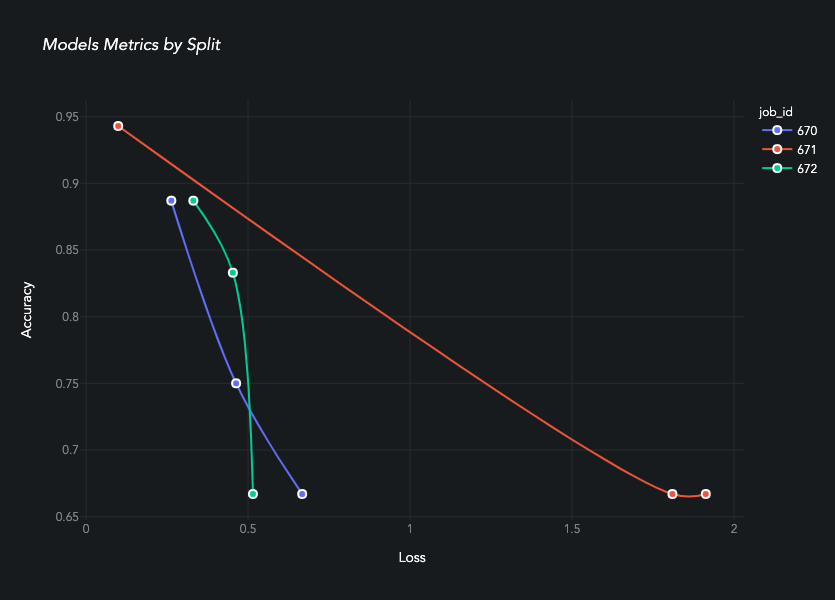

In [34]:
batch.plot_performance(max_loss=5, min_metric_2=0.5)

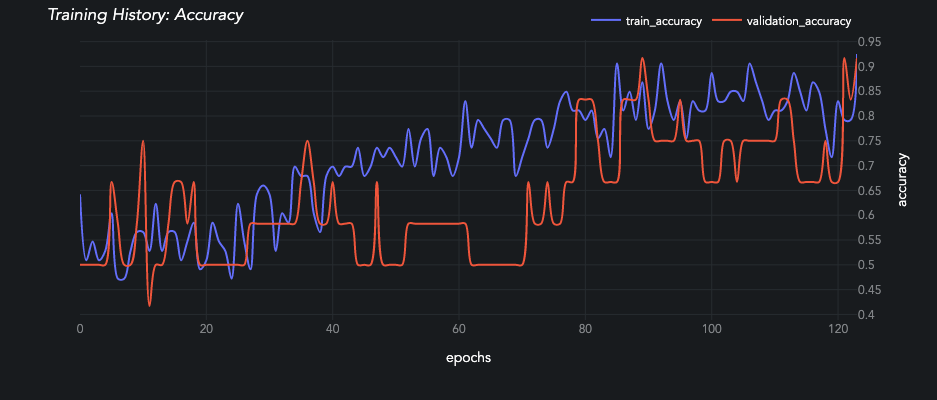

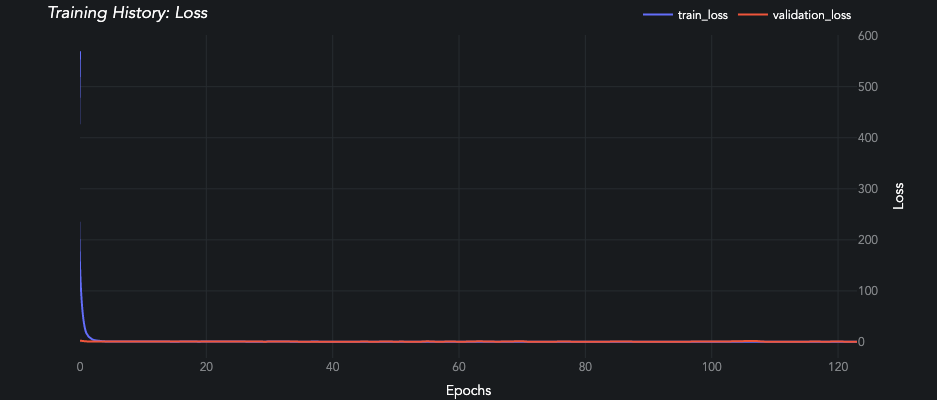

In [830]:
aiqc.Job.get_by_id(503).results[0].plot_learning_curve()

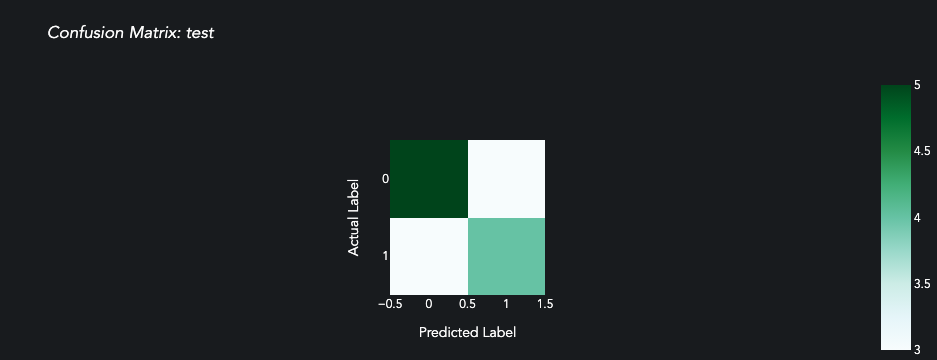

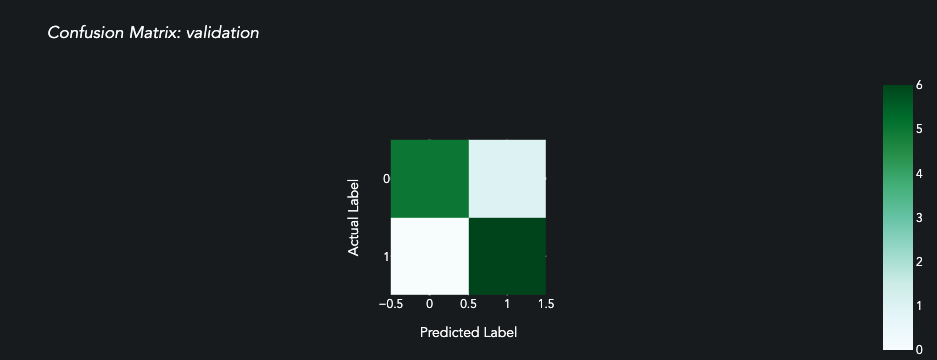

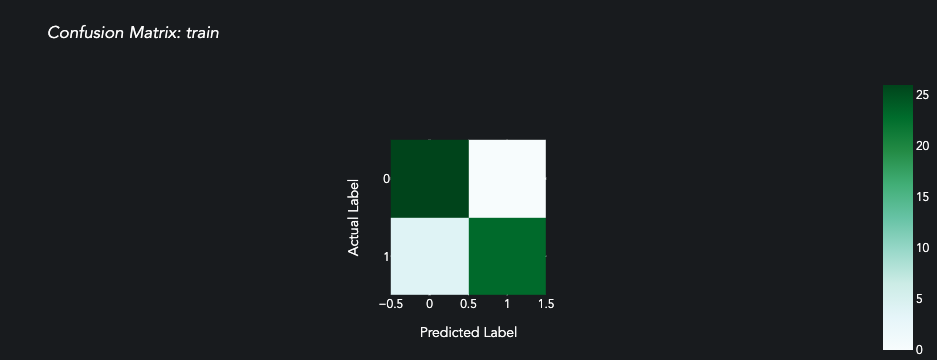

In [831]:
aiqc.Job.get_by_id(503).results[0].plot_confusion_matrix()

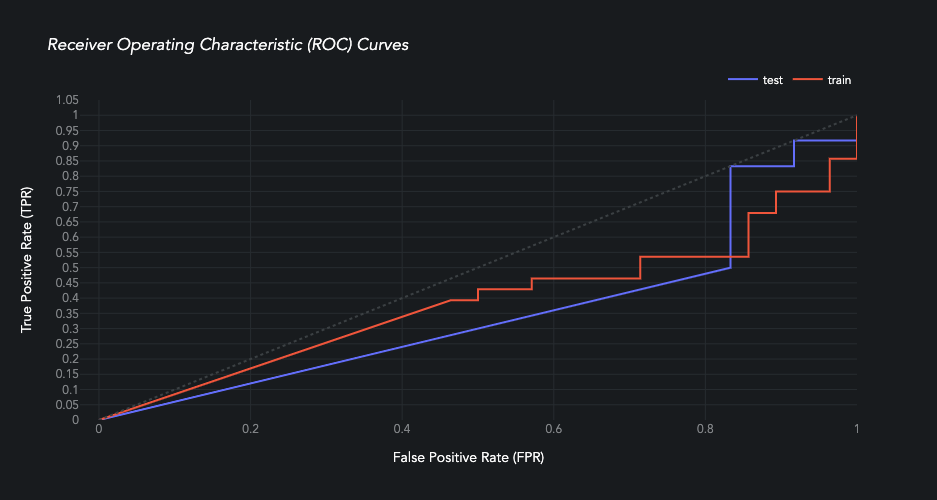

In [53]:
aiqc.Job.get_by_id(4).results[0].plot_roc_curve()